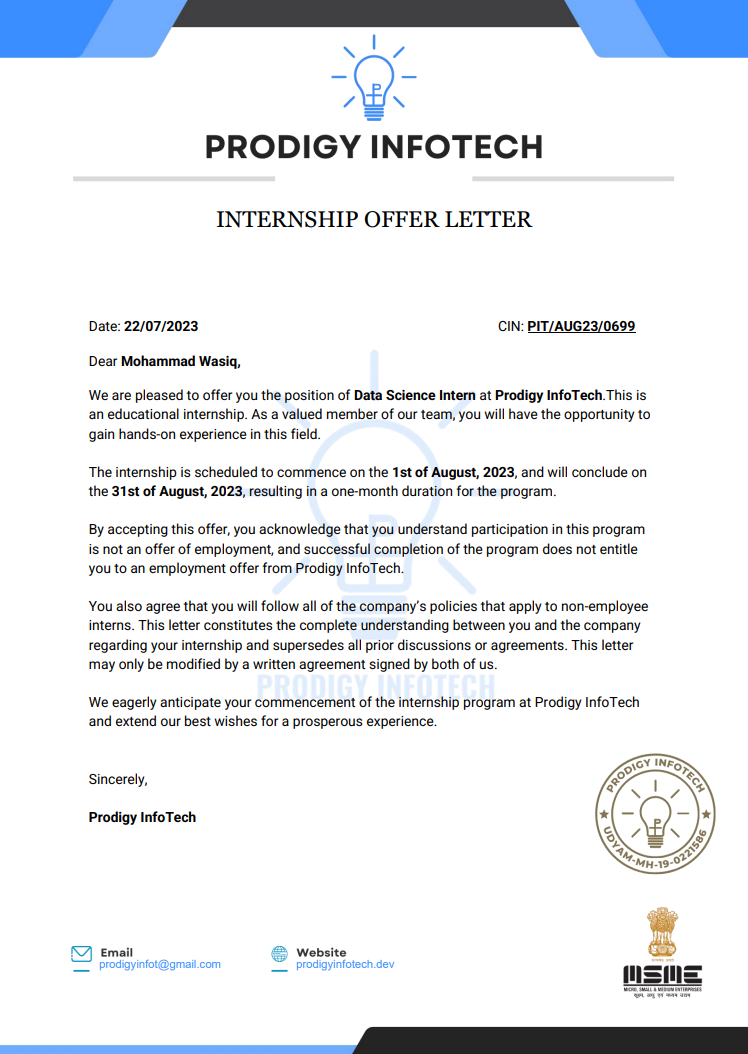

![](https://monkeylearn.com/static/6700dcab9bcc691104dd0d794f6e7ef4/Sentiment-analysis-of-Twitter-Social.png)

### <b><span style='color:#F1A425'>Test Classification</span></b>

- Text classification is one of the most common tasks in NLP
- It can be used for a wide range of applications (eg. tagging customer feedback into categories, routing support tickets according to their language)
- Another common type of text classification problem is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">sentiment analysis</mark>** which aims to **identify the polatity** of a given text (+/-)

### <b><span style='color:#F1A424'>Our Task</span></b>

- We need to build a system that will be able to automatically identify emotional states (eg. anger, joy) that people express about your company's product on twitter

## <div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>1 |</span></span></b>Import Libraries</b></p></div>

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
import zipfile
import os

def extract_zip(zip_file_path, output_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

zip_file_path = '/content/Twitter.zip'
output_folder = '/content/Twitter'
extract_zip(zip_file_path, output_folder)


In [3]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train = pd.read_csv("/content/Twitter/twitter_training.csv",
                    sep=',',names=column_names)


validation = pd.read_csv("/content/Twitter/twitter_validation.csv",
                    sep=',',names=column_names)

In [4]:
print(train.shape)
train.head(2)

(74682, 4)


,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...


In [5]:
print(validation.shape)
validation.head(2)

(1000, 4)


,Tweet_ID,Entity,Sentiment,Tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


## <div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>2 |</span></span></b> EDA</b></p></div>


    
- Many data sets involving **sentiment** analysis are **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">binary</mark>** classification problems
- In this dataset we have **4 different sentiments**, which means we'll be treating this problem as a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">multiclass</mark>** classification problem

In [6]:
# checking nan values
print("\t\t\tTrain dataset")
print(train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.isna().sum())

			Train dataset
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64
****************************************
			Validation dataset
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64


In [7]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.duplicated().sum())

			Train dataset
2700
****************************************
			Validation dataset
0


In [8]:
# remove dupicate and nan values
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [9]:
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_urls(x))

validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_emojis(x))
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [11]:
train['text_lens']=train['Tweet_content'].apply(lambda x: len(x))
validation['text_lens']=validation['Tweet_content'].apply(lambda x: len(x))

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>2 |</span></span></b> Data Visualition</b></p></div>

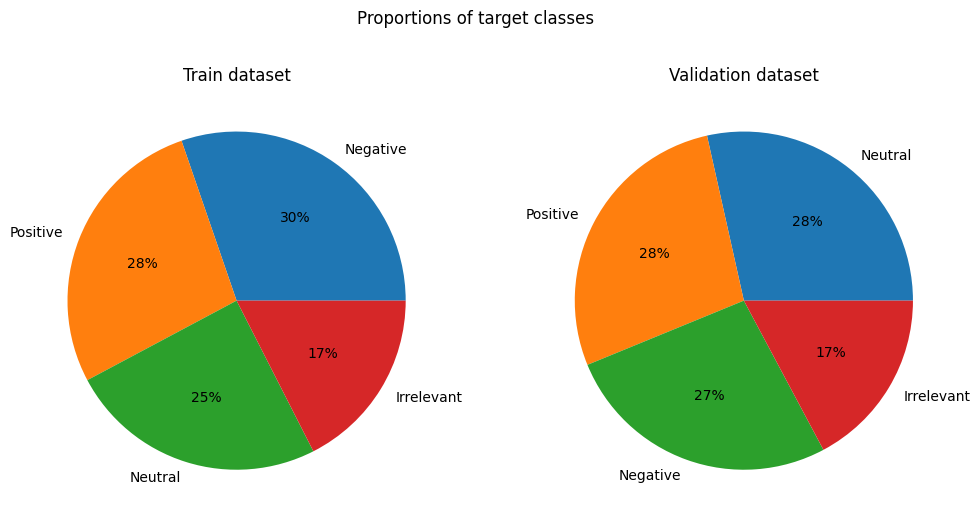

In [12]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(train['Sentiment'].value_counts(),labels=train['Sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(validation['Sentiment'].value_counts(),labels=validation['Sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

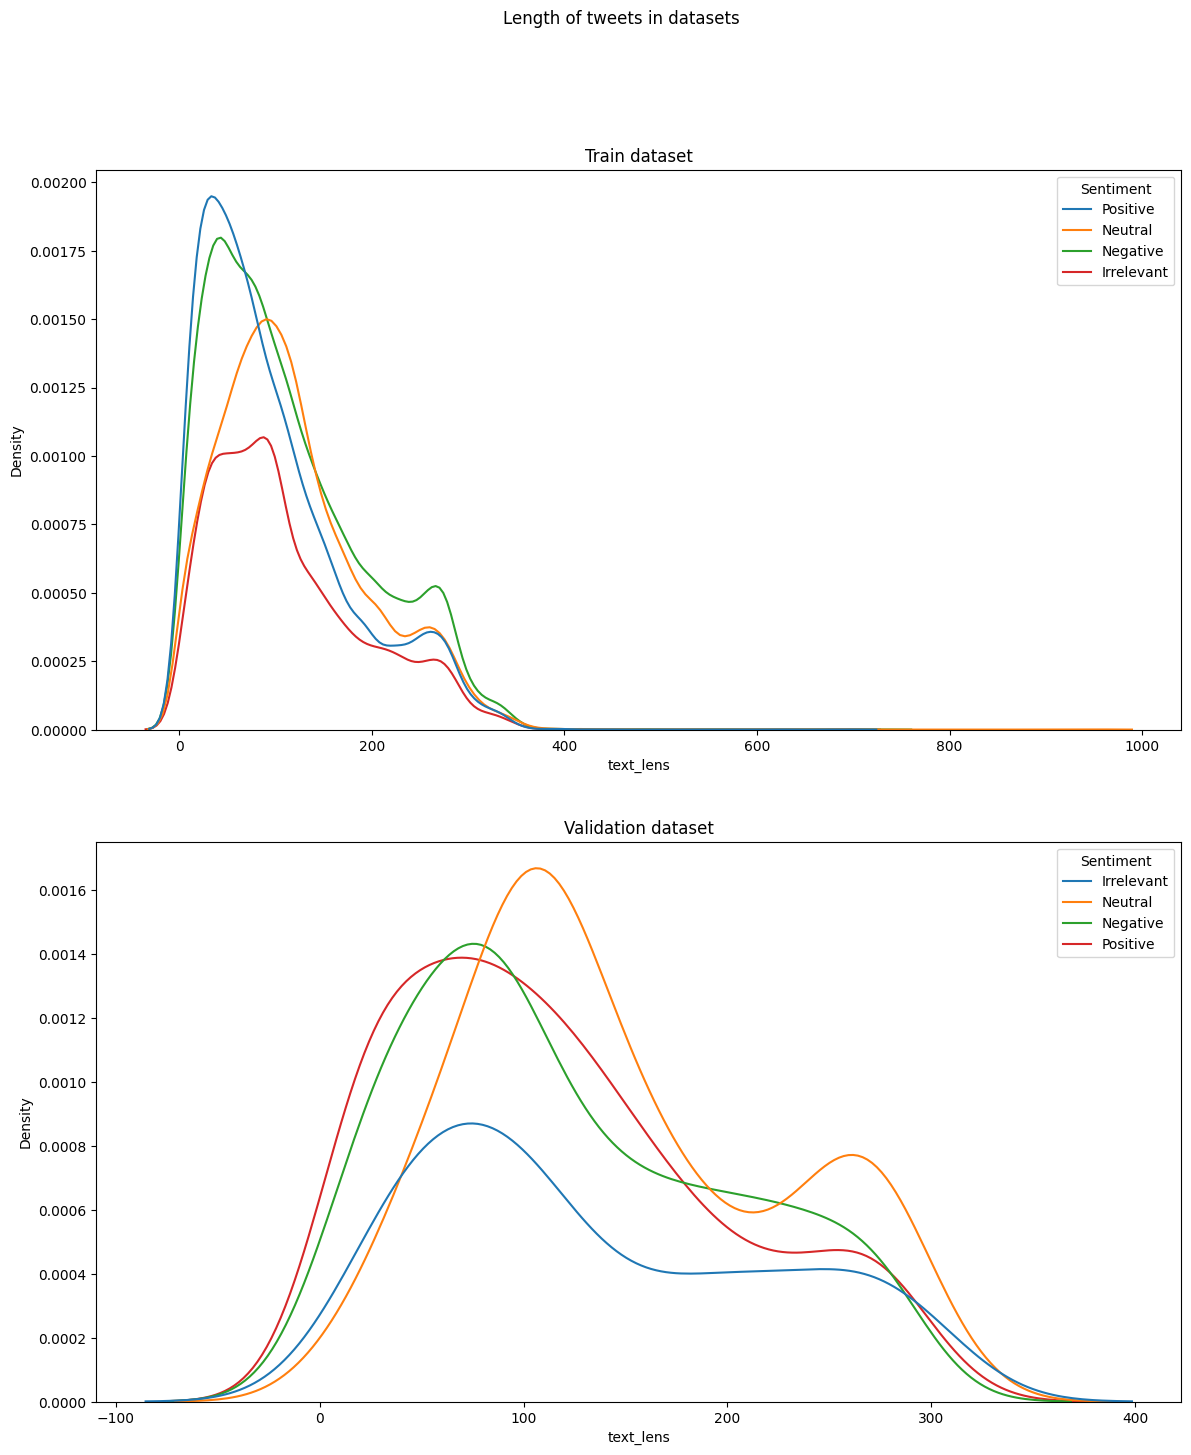

In [13]:
fig ,ax = plt.subplots(2,1,figsize=(14,16))

sns.kdeplot(data=train,x='text_lens',hue='Sentiment',ax=ax[0])
sns.kdeplot(data=validation,x='text_lens',hue='Sentiment',ax=ax[1])

fig.suptitle("Length of tweets in datasets")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [14]:
#Count information per category
data1=train.groupby(by=["Entity","Sentiment"]).count().reset_index()
data1.head()

,Entity,Sentiment,Tweet_ID,Tweet_content,text_lens
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185


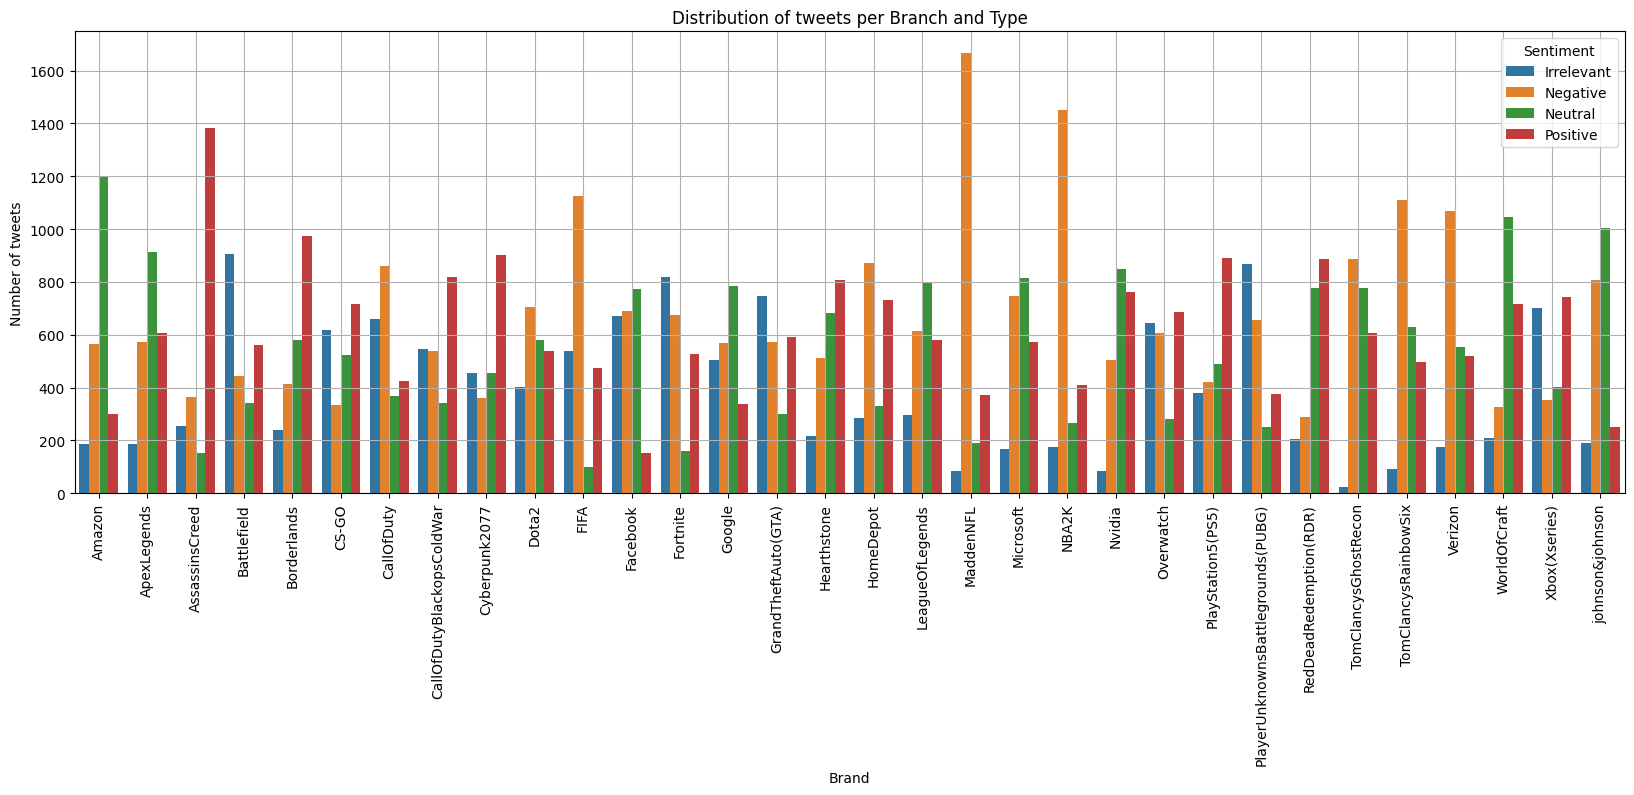

In [15]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data1,x="Entity",y="Tweet_ID",hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

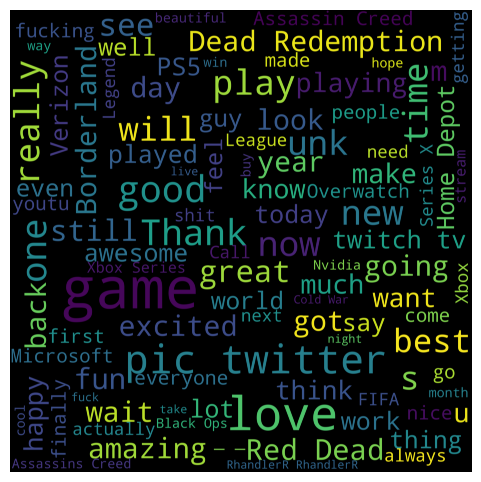

In [16]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Positive"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

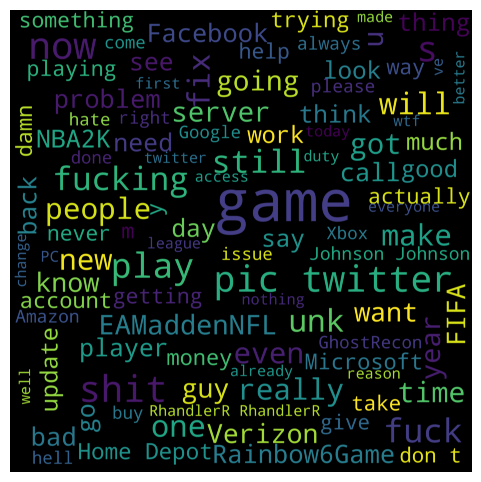

In [17]:
word_cloud_text_negative = ''.join(train[train["Sentiment"]=="Negative"].Tweet_content)
wordcloud_negative = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text_negative)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

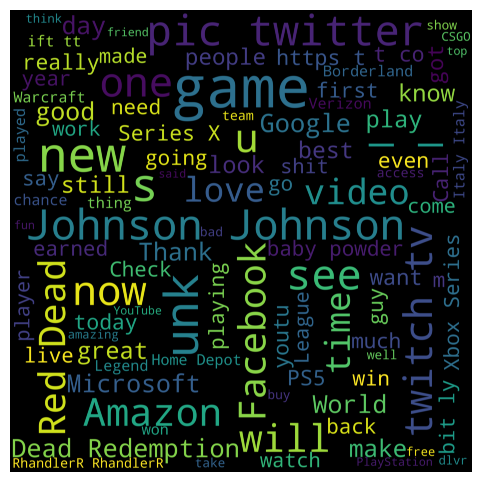

In [18]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Neutral"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

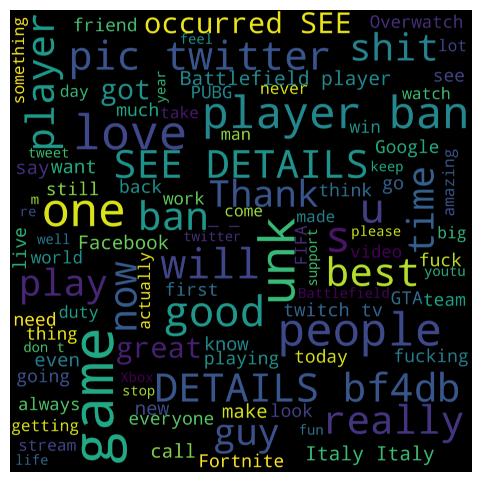

In [19]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Irrelevant"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

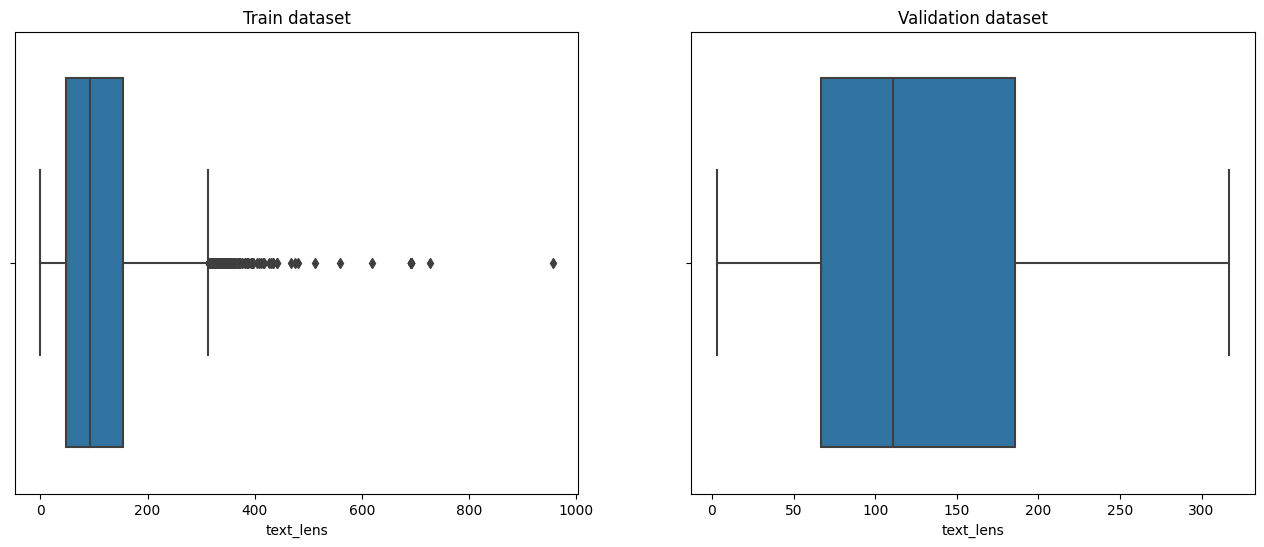

In [20]:
fig , ax = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=train,x='text_lens',ax=ax[0])
sns.boxplot(data=validation,x='text_lens',ax=ax[1])

ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'> 3 | </span></span></b> Data Preprocessing </b></p></div>

## <b>3.1 <span style='color:#F1A424'>|</span> Data Cleaning</b>

In [21]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

## <b>3.2 <span style='color:#F1A424'>|</span> Tokenazation and  Lemmatization</b>

In [22]:
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)


train['preprocessed_text']= train['Tweet_content'].apply(lambda x: preprocess(x))
validation['preprocessed_text']= validation['Tweet_content'].apply(lambda x: preprocess(x))

## <b>3.3 <span style='color:#F1A424'>|</span> Train Test Split</b>

In [23]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42
)

## <b>3.4 <span style='color:#F1A424'>|</span> Data Representation</b>
- In this step, we will convert text from text to vector

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

In [25]:
validation_X = vectorizer.transform(validation['preprocessed_text'])
validation_y = validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'> 4 | </span></span></b> Machine Learning </b></p></div>

- We test in this step **ML Models**
- We test three different **ML Models**


## <b>4.1 <span style='color:#F1A424'>|</span> MultinomialNB</b>

In [26]:
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      3900
           1       0.65      0.89      0.75      4238
           2       0.84      0.64      0.73      3518
           3       0.94      0.44      0.60      2516

    accuracy                           0.72     14172
   macro avg       0.78      0.69      0.70     14172
weighted avg       0.76      0.72      0.72     14172



## <b>4.2 <span style='color:#F1A424'>|</span> RandomForestClassifier</b>

In [27]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3900
           1       0.92      0.92      0.92      4238
           2       0.93      0.89      0.91      3518
           3       0.97      0.85      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.90      0.91     14172
weighted avg       0.91      0.91      0.91     14172



## <b>4.3 <span style='color:#F1A424'>|</span> ExtraTreesClassifier</b>

In [28]:
model_extra = ExtraTreesClassifier()
model_extra.fit(X_train_vect,y_train)
y_predict= model_extra.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3900
           1       0.94      0.93      0.94      4238
           2       0.95      0.91      0.93      3518
           3       0.98      0.88      0.93      2516

    accuracy                           0.92     14172
   macro avg       0.93      0.92      0.92     14172
weighted avg       0.93      0.92      0.92     14172



## <b>4.4 <span style='color:#F1A424'>|</span> Validation Test</b>

In [29]:
y_predict= model_extra.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       277
           1       0.96      0.98      0.97       266
           2       0.98      0.96      0.97       285
           3       1.00      0.94      0.97       172

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [30]:
import pickle
with open('model_extra.pkl', 'wb') as file:
    pickle.dump(model_extra, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [31]:
train.to_csv("train_data.csv")
validation.to_csv('validation_data.csv')

In [32]:
text = 'Your support team is useless'
text1='Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dlvr.it/RMTrgF '
text_final = vectorizer.transform([text1])

predict = model_extra.predict(text_final)

In [33]:
list(predict)[0]

2

In [34]:
kayfiyatlar={0:"Positive",1:"Negative",2:"Neutral",3:"Irrelevant"}
kayfiyatlar[list(predict)[0]]

'Neutral'

In [35]:
train[train['Sentiment']=='Neutral']['Tweet_content'][12]

'Rock-Hard La Varlope, RARE & POWERFUL, HANDSOME JACKPOT, Borderlands 3 (Xbox) dlvr.it/RMTrgF  '

In [36]:
train.iloc[0]

Tweet_ID                                                          2401
Entity                                                     Borderlands
Sentiment                                                     Positive
Tweet_content        im getting on borderlands and i will murder yo...
text_lens                                                           53
preprocessed_text                              m get borderland murder
Name: 0, dtype: object

# Deep Learning Approach

## RNN-LSTM

In [38]:
# import numpy as np
# import pandas as pd
# import warnings
# import matplotlib.pyplot as plt
# import seaborn as sns
# from wordcloud import WordCloud
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import classification_report

from keras.layers import Layer
from keras.utils import plot_model
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Attention
from keras.layers import Concatenate, Dense, Input
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from keras.layers import GlobalMaxPooling1D

from bs4 import BeautifulSoup
import re
import spacy
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Code

```python
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',
                 usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])

df = df[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]
````

```python
df.dropna(inplace=True)
```

```python
df.duplicated().sum()
````

```python
df.drop_duplicates(inplace=True)
````

```python
df.reset_index(inplace=True)
````

```python
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

x = df['tweet_content'].apply(lambda p: clean_text(p))
````

```python
import re
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
#1
def reviews(reviews):
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]

    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]
````

```python
#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)
````

```python
y = df['sentiment']
````

```python
max_words = 8000

tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)
````

```python
y = np.array(label_tokenizer.texts_to_sequences(y))


X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)
````

```python

````

```python

````

```python

````

In [49]:
df = pd.read_csv('/content/Twitter/twitter_training.csv',
                 usecols=[0,1,2,3], names=['Tweet_ID','entity', 'sentiment', 'tweet_content'])

df = df[['Tweet_ID', 'entity', 'tweet_content', 'sentiment']]

df.dropna(inplace=True)

df.duplicated().sum()

df.drop_duplicates(inplace=True)

df.reset_index(inplace=True)

replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

x = df['tweet_content'].apply(lambda p: clean_text(p))

In [51]:
import re
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer

#1
def reviews(reviews):
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]

    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
y = df['sentiment']

max_words = 8000

tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)

y = np.array(label_tokenizer.texts_to_sequences(y))

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

In [53]:
model_simple_rnn = Sequential()
model_simple_rnn.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_simple_rnn.add(SpatialDropout1D(0.2))
model_simple_rnn.add(SimpleRNN(128, dropout = 0.2, recurrent_dropout = 0.2))
model_simple_rnn.add(Dense(128, activation = 'relu'))
model_simple_rnn.add(Dropout(0.2))
model_simple_rnn.add(Dense(5, activation = 'softmax'))
model_simple_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

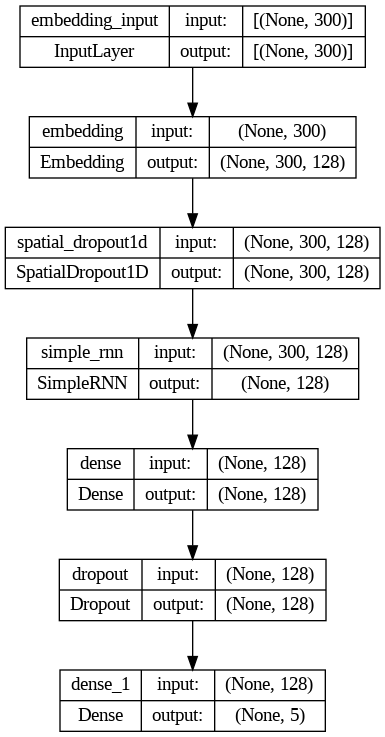

In [54]:
plot_model(model_simple_rnn, to_file="model.png", show_shapes=True)

In [55]:
history = model_simple_rnn.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test) ,
    epochs = 10,
    batch_size = 512
)

Epoch 1/10
112/112 [==============================] - 281s 2s/step - loss: 1.4036 - accuracy: 0.3173 - val_loss: 1.2991 - val_accuracy: 0.3853
Epoch 2/10
112/112 [==============================] - 259s 2s/step - loss: 1.1508 - accuracy: 0.5171 - val_loss: 1.0218 - val_accuracy: 0.5848
Epoch 3/10
112/112 [==============================] - 265s 2s/step - loss: 0.9628 - accuracy: 0.6148 - val_loss: 0.8682 - val_accuracy: 0.6600
Epoch 4/10
112/112 [==============================] - 257s 2s/step - loss: 0.8178 - accuracy: 0.6802 - val_loss: 0.8436 - val_accuracy: 0.6794
Epoch 5/10
112/112 [==============================] - 258s 2s/step - loss: 0.7077 - accuracy: 0.7305 - val_loss: 0.7367 - val_accuracy: 0.7224
Epoch 6/10
112/112 [==============================] - 263s 2s/step - loss: 0.6391 - accuracy: 0.7574 - val_loss: 0.7010 - val_accuracy: 0.7379
Epoch 7/10
112/112 [==============================] - 231s 2s/step - loss: 0.5737 - accuracy: 0.7812 - val_loss: 0.6214 - val_accuracy: 0.7679

In [56]:
model_simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 128)         0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                      

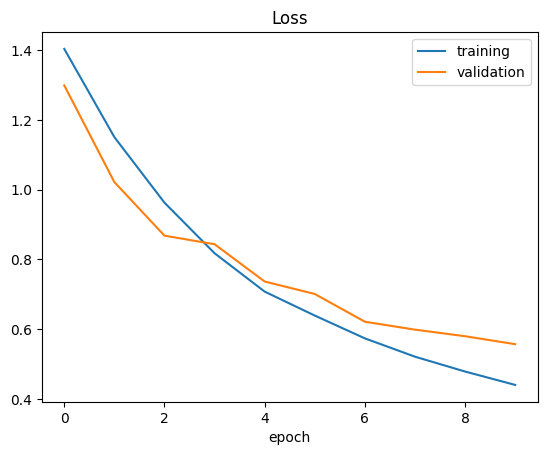

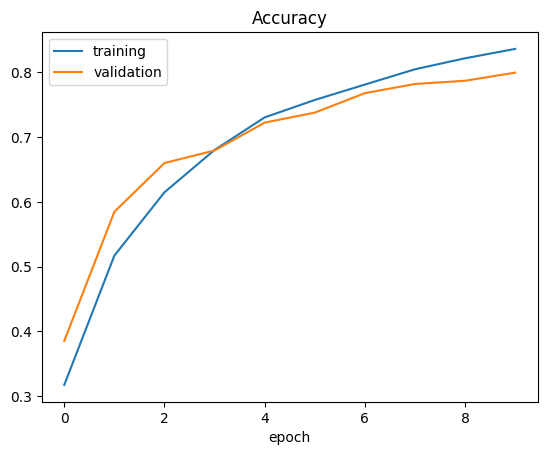

In [57]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## BERT

In [60]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:00


In [62]:
train

,Tweet_ID,Entity,Sentiment,Tweet_content,text_lens,preprocessed_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,m get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,m get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,m come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,m get borderland 2 murder
...,...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,128,realize Windows partition Mac like 6 year Nvid...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,117,realize Mac window partition 6 year Nvidia dri...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,125,realize window partition Mac 6 year Nvidia dri...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,159,realize window partition Mac like 6 year Nvidi...


In [64]:
train.columns

Index(['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content', 'text_lens',
       'preprocessed_text'],
      dtype='object')

In [65]:
train[['Tweet_content', 'Sentiment']]

,Tweet_content,Sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive
...,...,...
74677,Just realized that the Windows partition of my...,Positive
74678,Just realized that my Mac window partition is ...,Positive
74679,Just realized the windows partition of my Mac ...,Positive
74680,Just realized between the windows partition of...,Positive


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Load and preprocess the data
data = train[['Tweet_content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Split the data into training and testing sets
data_train, data_test = train_test_split(data, test_size=0.1)

# Extract the training and testing texts and labels
train_texts = data_train['Tweet_content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_content'].tolist()
test_labels = data_test['Sentiment'].tolist()

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Use smaller batch size
batch_size = 16

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset.batch(batch_size), epochs=2)

# Evaluate the model
model.evaluate(test_dataset.batch(batch_size))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


 741/3986 [====>.........................] - ETA: 24:51:44 - loss: 1.0758 - accuracy: 0.5497

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Make predictions on the training and test datasets
train_predictions = model.predict(train_dataset.batch(64))
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
train_predicted_sentiments = data['Sentiment_label'].cat.categories[train_predicted_labels]
test_predicted_sentiments = data['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
train_true_labels = data_train['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the training set
train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
print("Training Set - Classification Report:\n", train_classification_rep)

# Generate the confusion matrix for the training set
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(train_true_labels)

# Plot the confusion matrix for the training set
train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
train_display.plot(cmap='Blues')
plt.title("Training Set - Confusion Matrix")
plt.grid(False)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# Load and preprocess the data
data_val = validation[['Tweet_content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and testing texts and labels
val_texts = data_val['Tweet_content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Make predictions on the training and test datasets

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the training set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Training Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the training set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

# Plot the confusion matrix for the training set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
plt.show()

## Roberta

In [ ]:

from transformers import TFRobertaModel, RobertaTokenizer

#Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')

#Load and preprocess the data
data = train[['Tweet_content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

#Split the data into training and testing sets
data_train, data_test = train_test_split(data, test_size=0.1)

#Extract the training and testing texts and labels
train_texts = data_train['Tweet_content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_content'].tolist()
test_labels = data_test['Sentiment'].tolist()

#Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

#Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

#Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

#Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :]) # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

#Use smaller batch size
batch_size = 16

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset.batch(batch_size), epochs=2)

#Evaluate the model
model.evaluate(test_dataset.batch(batch_size))

In [ ]:
# Make predictions on the training and test datasets
train_predictions = model.predict(train_dataset.batch(64))
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
train_predicted_sentiments = data['Sentiment_label'].cat.categories[train_predicted_labels]
test_predicted_sentiments = data['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
train_true_labels = data_train['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the training set
train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
print("Training Set - Classification Report:\n", train_classification_rep)

# Generate the confusion matrix for the training set
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(train_true_labels)

# Plot the confusion matrix for the training set
train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
train_display.plot(cmap='Blues')
plt.title("Training Set - Confusion Matrix")
plt.grid(False)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.show()



In [ ]:
# Load and preprocess the data
data_val = validation[['Tweet_content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and testing texts and labels
val_texts = data_val['Tweet_content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Make predictions on the training and test datasets

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the training set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Training Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the training set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

# Plot the confusion matrix for the training set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
plt.show()




## DistilBERT

In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer

#Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

#Load and preprocess the data
data = train[['Tweet_content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

#Split the data into training and testing sets
data_train, data_test = train_test_split(data, test_size=0.1)

#Extract the training and testing texts and labels
train_texts = data_train['Tweet_content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_content'].tolist()
test_labels = data_test['Sentiment'].tolist()

#Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

#Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

#Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

#Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :]) # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

#Use smaller batch size
batch_size = 16

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset.batch(batch_size), epochs=2)

#Evaluate the model
model.evaluate(test_dataset.batch(batch_size))

In [ ]:
# Make predictions on the training and test datasets
train_predictions = model.predict(train_dataset.batch(64))
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
train_predicted_sentiments = data['Sentiment_label'].cat.categories[train_predicted_labels]
test_predicted_sentiments = data['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
train_true_labels = data_train['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the training set
train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
print("Training Set - Classification Report:\n", train_classification_rep)

# Generate the confusion matrix for the training set
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(train_true_labels)

# Plot the confusion matrix for the training set
train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
train_display.plot(cmap='Blues')
plt.title("Training Set - Confusion Matrix")
plt.grid(False)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.show()



In [ ]:
# Load and preprocess the data
data_val = validation[['Tweet_content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and testing texts and labels
val_texts = data_val['Tweet_content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Make predictions on the training and test datasets

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the training set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Training Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the training set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

# Plot the confusion matrix for the training set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
plt.show()




## XLNet

In [ ]:
from transformers import TFXLNetModel, XLNetTokenizer

# Load the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = TFXLNetModel.from_pretrained('xlnet-base-cased')

# Load and preprocess the data
data = train[['Tweet_content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

# Split the data into training and testing sets
data_train, data_test = train_test_split(data, test_size=0.1)

# Extract the training and testing texts and labels
train_texts = data_train['Tweet_content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_content'].tolist()
test_labels = data_test['Sentiment'].tolist()

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model(input_ids=input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :])  # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

# Use smaller batch size
batch_size = 16

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset.batch(batch_size), epochs=2)

# Evaluate the model
model.evaluate(test_dataset.batch(batch_size))

In [ ]:
# Make predictions on the training and test datasets
train_predictions = model.predict(train_dataset.batch(64))
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
train_predicted_sentiments = data['Sentiment_label'].cat.categories[train_predicted_labels]
test_predicted_sentiments = data['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
train_true_labels = data_train['Sentiment_label']
test_true_labels = data_test['Sentiment_label']

# Calculate the classification report for the training set
train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
print("Training Set - Classification Report:\n", train_classification_rep)

# Generate the confusion matrix for the training set
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(train_true_labels)

# Plot the confusion matrix for the training set
train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
train_display.plot(cmap='Blues')
plt.title("Training Set - Confusion Matrix")
plt.grid(False)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.show()



In [ ]:
# Load and preprocess the data
data_val = validation[['Tweet_content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes

# Extract the training and testing texts and labels
val_texts = data_val['Tweet_content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Make predictions on the training and test datasets

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the training set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Training Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the training set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

# Plot the confusion matrix for the training set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
plt.show()